# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [1]:
print('This data represents 17 marketing campaigns')

This data represents 17 marketing campaigns


### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [33]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score

In [3]:
df_bank = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
df_bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [5]:
#checking dataset for missing/null values
df_bank.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [6]:
#checking for "unknown" and its columnwise percentage
(df_bank.apply(lambda col: col.value_counts().get('unknown', 0)) / len(df_bank))*100


age                0.000000
job                0.801204
marital            0.194231
education          4.202680
default           20.872584
housing            2.403613
loan               2.403613
contact            0.000000
month              0.000000
day_of_week        0.000000
duration           0.000000
campaign           0.000000
pdays              0.000000
previous           0.000000
poutcome           0.000000
emp.var.rate       0.000000
cons.price.idx     0.000000
cons.conf.idx      0.000000
euribor3m          0.000000
nr.employed        0.000000
y                  0.000000
dtype: float64

In [7]:
#Cloumn default has upwards of 20% unknown values hence dropping the column
df_bank.drop(columns=['default'], inplace=True)

#Column duration to be dropped as we are building a predictive model, based on column description provided above
df_bank.drop(columns=['duration'], inplace=True)

df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   housing         41188 non-null  object 
 5   loan            41188 non-null  object 
 6   contact         41188 non-null  object 
 7   month           41188 non-null  object 
 8   day_of_week     41188 non-null  object 
 9   campaign        41188 non-null  int64  
 10  pdays           41188 non-null  int64  
 11  previous        41188 non-null  int64  
 12  poutcome        41188 non-null  object 
 13  emp.var.rate    41188 non-null  float64
 14  cons.price.idx  41188 non-null  float64
 15  cons.conf.idx   41188 non-null  float64
 16  euribor3m       41188 non-null  float64
 17  nr.employed     41188 non-null 

In [8]:
#Excluding poutcome (past outcome) and contact(tellephone or cellular) which is almost same value
#drop poutcome and contact columns
df_bank.drop(columns=['poutcome'], inplace=True)
df_bank.drop(columns=['contact'], inplace=True)

df_bank.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   housing         41188 non-null  object 
 5   loan            41188 non-null  object 
 6   month           41188 non-null  object 
 7   day_of_week     41188 non-null  object 
 8   campaign        41188 non-null  int64  
 9   pdays           41188 non-null  int64  
 10  previous        41188 non-null  int64  
 11  emp.var.rate    41188 non-null  float64
 12  cons.price.idx  41188 non-null  float64
 13  cons.conf.idx   41188 non-null  float64
 14  euribor3m       41188 non-null  float64
 15  nr.employed     41188 non-null  float64
 16  y               41188 non-null  object 
dtypes: float64(5), int64(4), object

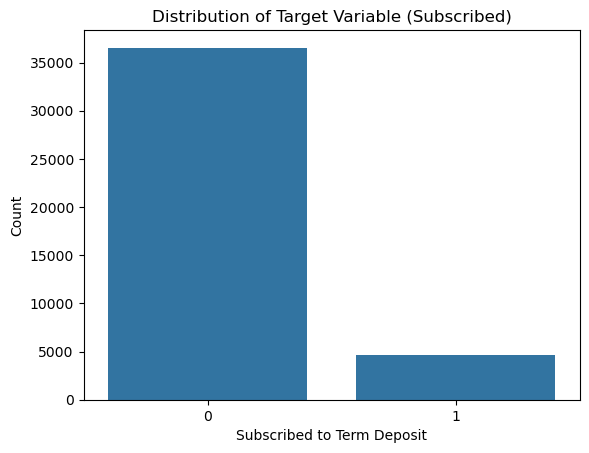

In [34]:
sns.countplot(x='y', data=df_bank)
plt.title("Distribution of Target Variable (Subscribed)")
plt.xlabel("Subscribed to Term Deposit")
plt.ylabel("Count")
plt.show()

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [9]:
print ('Business Objective: Build a predicitve model that will help idenitfy whether an individual is likely to subscribe to term deposit. This model will utilize client personal data, campaign data, and socio-economic data. While building the model we will also compare performance of different classifiers like Logistic Regression, K Nearest Neighbor (KNN), Support Vector Machines (SVM), and Decision Trees. A Portugese bank dataset compiled over 17 different marketing campaigns will be utilized for this analysis.')

Business Objective: Build a predicitve model that will help idenitfy whether an individual is likely to subscribe to term deposit. This model will utilize client personal data, campaign data, and socio-economic data. While building the model we will also compare performance of different classifiers like Logistic Regression, K Nearest Neighbor (KNN), Support Vector Machines (SVM), and Decision Trees. A Portugese bank dataset compiled over 17 different marketing campaigns will be utilized for this analysis.


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [10]:
#Selecting features from just the bank information group, which will be used to build basic model. Further feature engineering will be addressed as we will try to improve the model later
features = ['age', 'job', 'marital', 'education', 'housing', 'loan', 'month', 'day_of_week']

numerical_selector = selector(dtype_exclude=object)
categorical_selector = selector(dtype_include=object)

numerical_columns = numerical_selector(df_bank[features])
categorical_columns = categorical_selector(df_bank[features]) 

# Applying One-hot encoding on categorical features and standard scalar on numerical features
categorical_preprocessor = OneHotEncoder(drop='first') # dropping first to avoid multicollinearity
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer(
    [
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
        ("standard_scaler", numerical_preprocessor, numerical_columns),
    ]
)


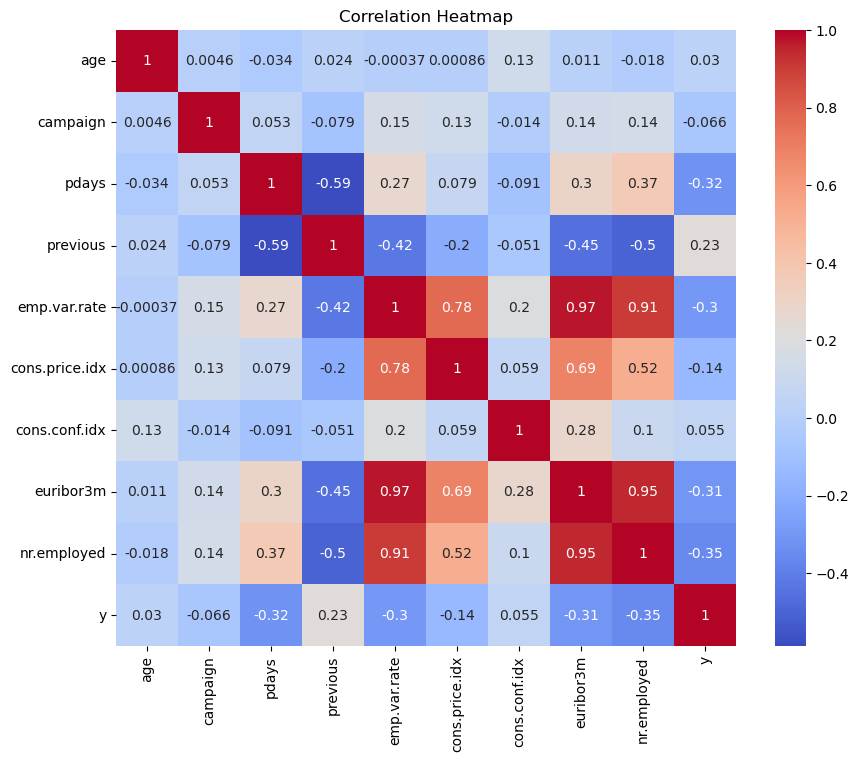

In [37]:
numerical_cols = numerical_selector(df_bank)
plt.figure(figsize=(10,8))
sns.heatmap(df_bank[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [11]:
#processing the target column ['y']
df_bank['y'] = df_bank['y'].str.strip().map({'yes': 1, 'no': 0})
y = df_bank['y']

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_bank[features], y, test_size=0.25, random_state=42)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(X_train_processed.shape)
print(X_test_processed.shape)

(30891, 39)
(10297, 39)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [13]:
#To determine baseline, we review the class distribution of the provided target column in the data set
df_bank['y'].value_counts(normalize=True)


y
0    0.887346
1    0.112654
Name: proportion, dtype: float64

In [14]:
print ('Baseline has been determined to be 88.73%, based on majority class (y = O) or (y = no). Classifiers must aim to beat 88.73% accuracy')

Baseline has been determined to be 88.73%, based on majority class (y = O) or (y = no). Classifiers must aim to beat 88.73% accuracy


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [15]:
#Building base model using logistic regression
log_r = LogisticRegression(max_iter=1000)
log_r.fit(X_train_processed, y_train)

#Prediction from Logistic Regression Model
y_pred = log_r.predict(X_test_processed)

### Problem 9: Score the Model

What is the accuracy of your model?

In [16]:
#Evaluating accuracy of the Logistic Regression model
print("Logistic Regression Model Accuracy:", accuracy_score(y_test, y_pred))

Logistic Regression Model Accuracy: 0.8872487132174419


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [17]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC()
}

# Prepare result storage
results = []

# Train and evaluate each model
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_processed, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test_processed)
    train_accuracy = accuracy_score(y_train, model.predict(X_train_processed))
    test_accuracy = accuracy_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Train Time": round(train_time, 5),
        "Train Accuracy" : round(train_accuracy, 5),
        "Test Accuracy": round(test_accuracy, 5)
    })

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)

,Model,Train Time,Train Accuracy,Test Accuracy
0,Support Vector Machine,70.81005,0.89227,0.88987
1,Logistic Regression,0.06590,0.88608,0.88725
2,K-Nearest Neighbors,0.00345,0.90101,0.88346
3,Decision Tree,0.64573,0.96980,0.83393


#### Findings of Model Comparison

As seen in the comparions table above:
- Decision Tress has the best Train Accuracy of 96.98% which is a lot better than baseline accuracy of 88.73%
- KNN had the lowest training time, followed by Logisitc Regression, Decision Tree, and finally Supprot Vector Machine in that order

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [18]:
#Adding socio-economic features in the feature mix
features_2 = ['age', 'job', 'marital', 'education', 'housing', 'loan', 'month', 'day_of_week', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed' ]
  
numerical_selector = selector(dtype_exclude=object)
categorical_selector = selector(dtype_include=object)

numerical_columns_2 = numerical_selector(df_bank[features_2])
categorical_columns_2 = categorical_selector(df_bank[features_2]) 

# Applying One-hot encoding on categorical features and standard scalar on numerical features
categorical_preprocessor = OneHotEncoder(drop='first') # dropping first to avoid multicollinearity
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer(
    [
        ("one-hot-encoder", categorical_preprocessor, categorical_columns_2),
        ("standard_scaler", numerical_preprocessor, numerical_columns_2),
    ]
)

#Train test split of data
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_bank[features_2], y, test_size=0.25, random_state=42)
X_train_processed_2 = preprocessor.fit_transform(X_train_2)
X_test_processed_2 = preprocessor.transform(X_test_2)

print(X_train_processed_2.shape)
print(X_test_processed_2.shape)

(30891, 44)
(10297, 44)


In [26]:
#Hyperparameter tuning using GridSearchCV
#KNN

param_grid = {'n_neighbors': range(3, 20)}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_knn.fit(X_train_processed_2, y_train)

print("Best params for KNN:", grid_knn.best_params_)
print("Best Score:", grid_knn.best_score_)
print(grid_knn.best_estimator_)

Best params for KNN: {'n_neighbors': 18}
Best Score: 0.8890615102029761
KNeighborsClassifier(n_neighbors=18)


In [27]:
#Decision Tree

param_grid_2 = {
    'max_depth': [3, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10]
}
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_2, cv=5)
grid_dt.fit(X_train_processed_2, y_train)

print("Best params for DT:", grid_dt.best_params_)
print(grid_dt.best_score_)
print(grid_dt.best_estimator_)

Best params for DT: {'max_depth': 3, 'min_samples_split': 2}
0.8921368972308855
DecisionTreeClassifier(max_depth=3)


In [ ]:
#Logistic Regression
param_grid_3 = {
    'C': [0.01, 0.1, 1, 10, 100]
}
grid_lr = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), param_grid_3, cv=5)
grid_lr.fit(X_train_processed_2, y_train)

print("Best parm for LogReg:", grid_3.best_params_)
print(grid_lr.best_score_)
print(grid_lr.best_estimator_)

Best parm for LogReg: {'C': 1}
0.8302092201203012
LogisticRegression(C=1, class_weight='balanced', max_iter=1000)


In [ ]:
#Support Vector Machine
param_grid_4 = {
    'C': [1, 10], 
    'gamma': [0.001, 0.01, 1]
}
grid_4 = GridSearchCV(SVC(), param_grid=param_grid_4)
grid_4.fit(X_train_processed_2, y_train)

print ("Best params for SVC:")
print(grid_4.best_params_)
print(grid_4.best_score_)
print(grid_4.best_estimator_)

Best params for SVC:
{'C': 10, 'gamma': 0.01}
0.8912951484971575
SVC(C=10, gamma=0.01)


In [29]:
#KNN:  Precision, Recall, F-1Score, and Support using Classification Report and ROC Area Under Curve (ROC_AUC)

y_pred_knn = grid_knn.predict(X_test_processed_2)
print(classification_report(y_test_2, y_pred_knn))
print("ROC AUC KNN:", roc_auc_score(y_test_2, y_pred_knn))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      9144
           1       0.53      0.15      0.24      1153

    accuracy                           0.89     10297
   macro avg       0.72      0.57      0.59     10297
weighted avg       0.86      0.89      0.86     10297

ROC AUC KNN: 0.5682261042174586


In [30]:
#Decision Tree: Calcualate Precision, Recall, F-1Score, and Support using Classification Report and ROC Area Under Curve (ROC_AUC)
y_pred_dt = grid_dt.predict(X_test_processed_2)
print(classification_report(y_test_2, y_pred_dt))
print("ROC AUC DT:", roc_auc_score(y_test_2, y_pred_dt))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      9144
           1       0.56      0.24      0.33      1153

    accuracy                           0.89     10297
   macro avg       0.74      0.61      0.64     10297
weighted avg       0.87      0.89      0.87     10297

ROC AUC DT: 0.6068491967016699


In [ ]:
#Logistic Regression: Calcualate Precision, Recall, F-1Score, and Support using Classification Report and ROC Area Under Curve (ROC_AUC)

y_pred_lr = grid_lr.predict(X_test_processed_2)
print(classification_report(y_test_2, y_pred_lr))
print("ROC AUC LR:", roc_auc_score(y_test_2, y_pred_lr))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      9144
           1       0.34      0.59      0.43      1153

    accuracy                           0.83     10297
   macro avg       0.64      0.72      0.67     10297
weighted avg       0.88      0.83      0.85     10297

ROC AUC LR: 0.7235831210604313


In [ ]:
#Support Vector Machine: Calcualate Precision, Recall, F-1Score, and Support using Classification Report and ROC Area Under Curve (ROC_AUC)

y_pred_svc = grid_4.predict(X_test_processed_2)
print(classification_report(y_test_2, y_pred_svc))
print("ROC AUC LR:", roc_auc_score(y_test_2, y_pred_svc))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      9144
           1       0.57      0.18      0.27      1153

    accuracy                           0.89     10297
   macro avg       0.74      0.58      0.61     10297
weighted avg       0.87      0.89      0.87     10297

ROC AUC LR: 0.579395471814939


#### Findings after improving the model via additional feature engineering and hyperparameter tuning using GridSearchCV

- Additional feature engineering was done, socio-economic features were added into the feature mix 
- Decision Tree had the best score followed by SVC, KNN, and finally Logistic Regression



##### Questions